In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
np.random.seed(42)
df = pd.read_csv("D:/Projects2.0/British Airways/Data/customer_booking.csv", encoding="ISO-8859-1")
print(f"Dataset shape: {df.shape}")

Dataset shape: (50000, 14)


In [ ]:
print("\n--- First 5 rows of the dataset ---")
display(df.head())
print("\n--- Data information ---")
df.info()
print("\n--- Summary statistics ---")
display(df.describe())


--- First 5 rows of the dataset ---


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0



--- Data information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), obj

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000



--- Target Variable Distribution ---
booking_complete
0    85.044
1    14.956
Name: proportion, dtype: float64


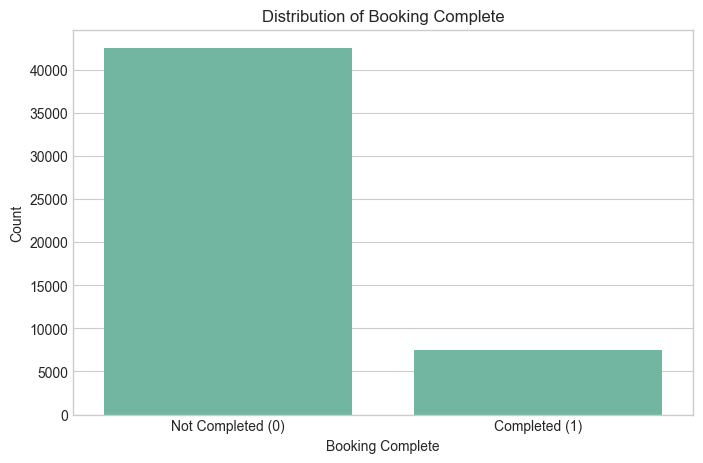


Imbalance ratio: 5.69
This means there are 5.69 times more non-bookings than bookings.


In [ ]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}
df["flight_day"] = df["flight_day"].map(mapping)
print("\n--- Target Variable Distribution ---")
print(df['booking_complete'].value_counts(normalize=True) * 100)
plt.figure(figsize=(8, 5))
sns.countplot(x='booking_complete', data=df)
plt.title('Distribution of Booking Complete')
plt.xlabel('Booking Complete')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Completed (0)', 'Completed (1)'])
plt.show()
print(f"\nImbalance ratio: {(df['booking_complete'] == 0).sum() / (df['booking_complete'] == 1).sum():.2f}")
print(f"This means there are {(df['booking_complete'] == 0).sum() / (df['booking_complete'] == 1).sum():.2f} times more non-bookings than bookings.")

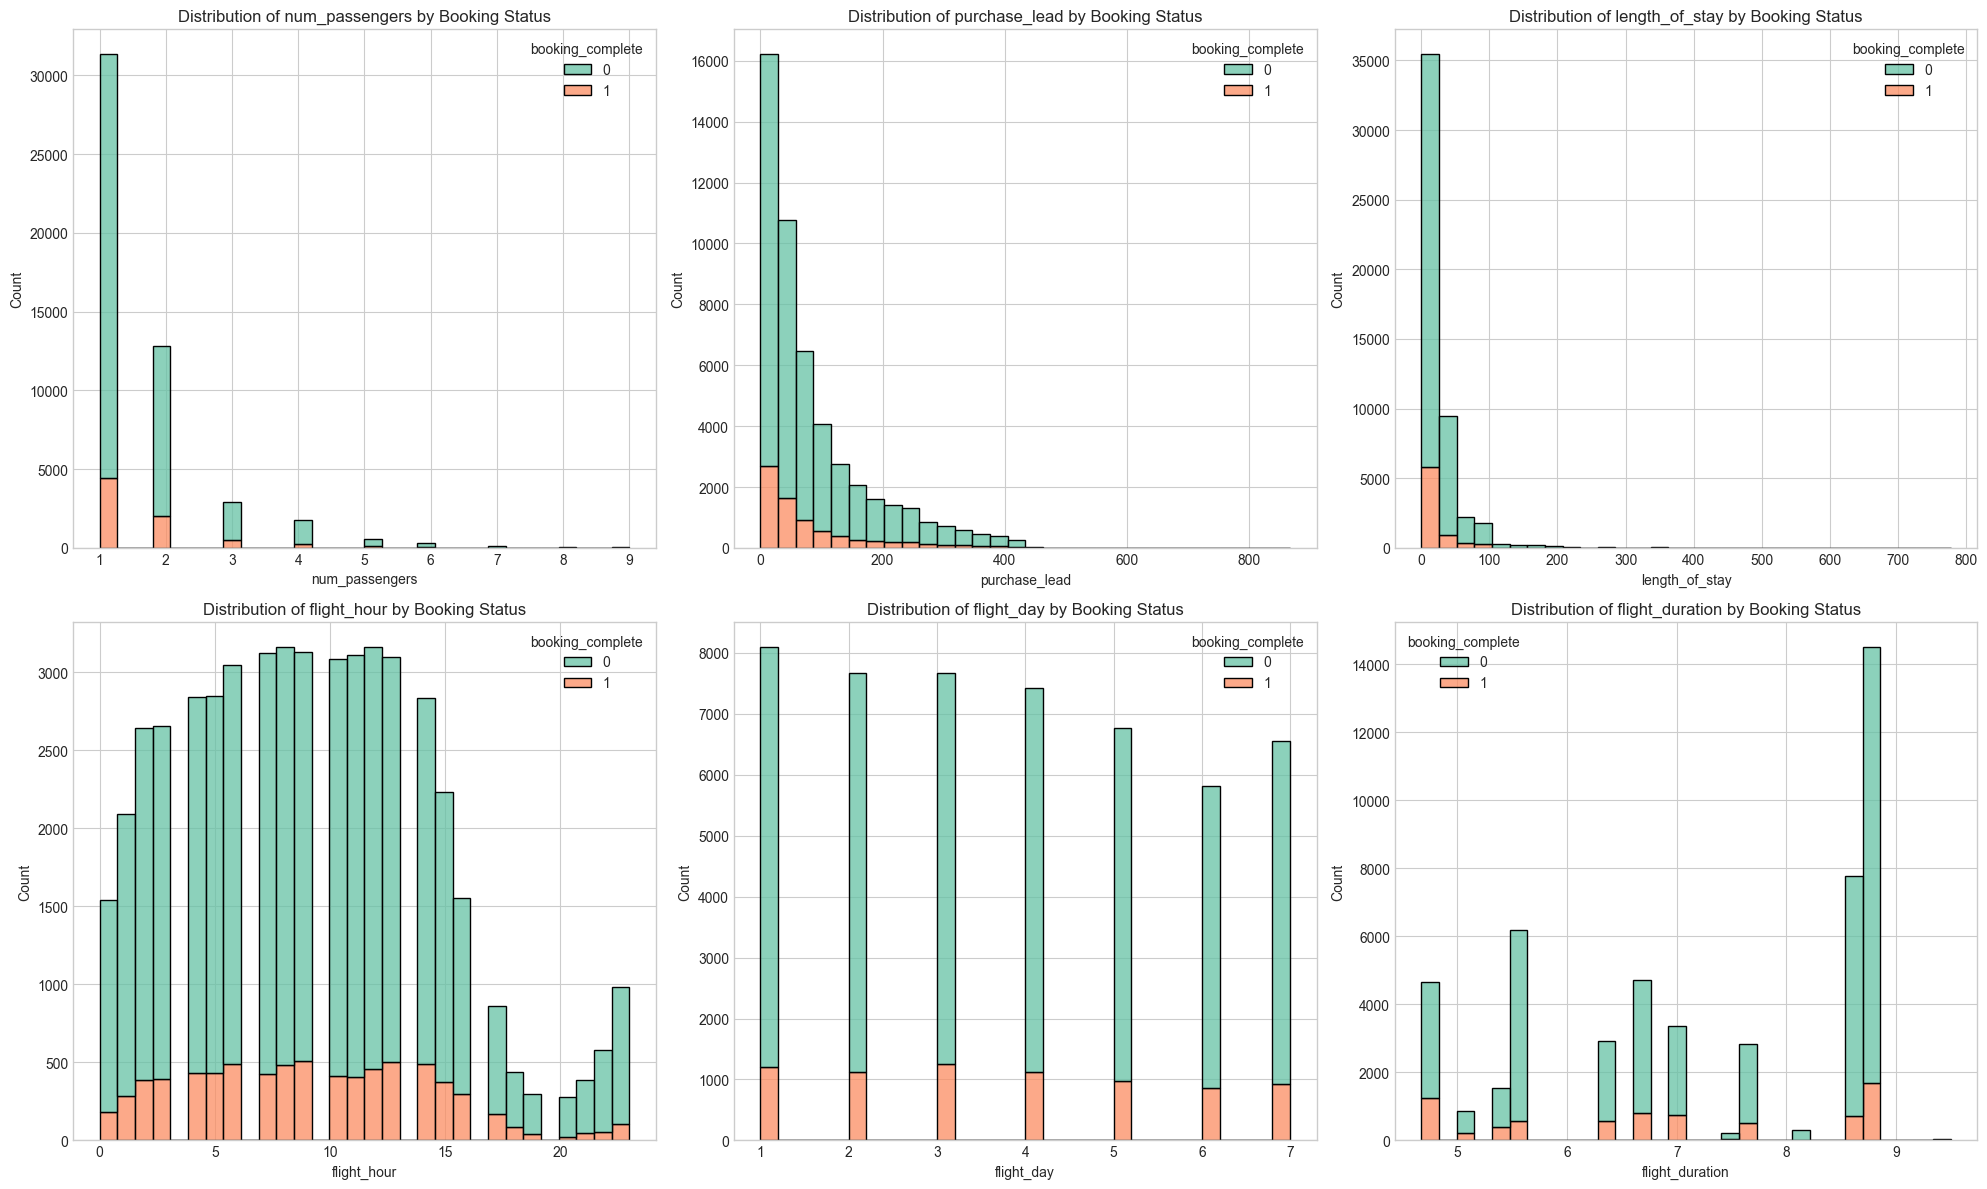

In [ ]:
plt.figure(figsize=(20, 12))
numerical_features = ['num_passengers', 'purchase_lead', 'length_of_stay', 
                    'flight_hour', 'flight_day', 'flight_duration']
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df, x=feature, hue='booking_complete', multiple='stack', bins=30)
    plt.title(f'Distribution of {feature} by Booking Status')
    plt.xlabel(feature)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

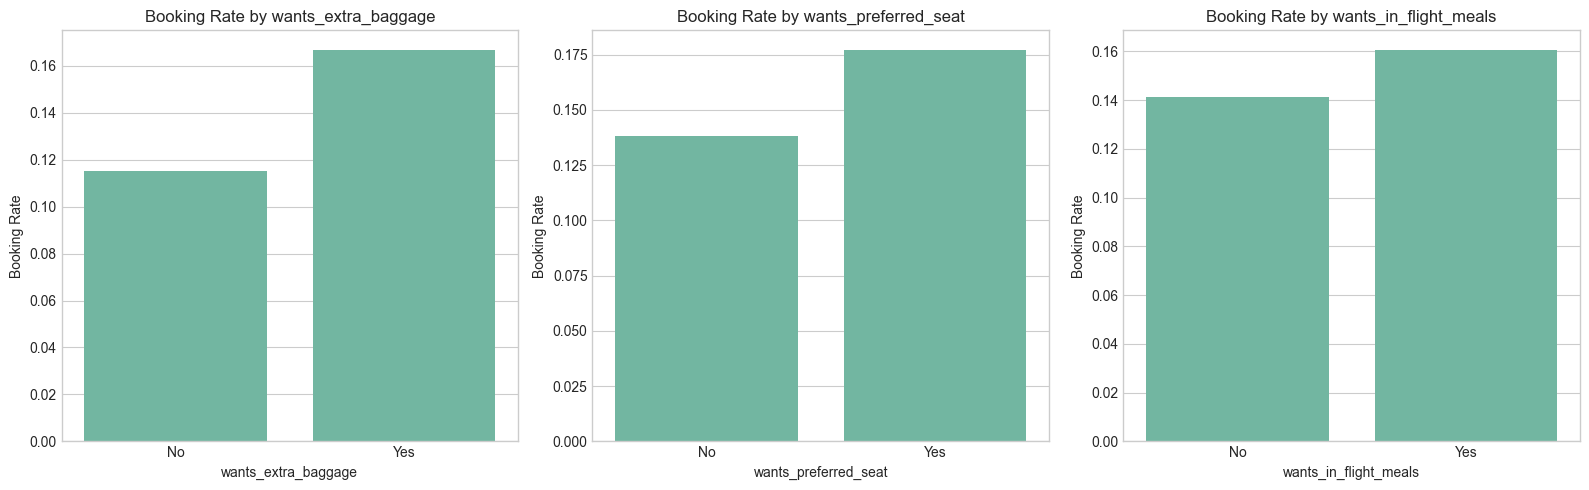

In [ ]:
plt.figure(figsize=(16, 5))
binary_features = ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']
for i, feature in enumerate(binary_features):
    plt.subplot(1, 3, i+1)
    booking_rates = df.groupby(feature)['booking_complete'].mean()
    sns.barplot(x=booking_rates.index, y=booking_rates.values)
    plt.title(f'Booking Rate by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Booking Rate')
    plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.show()

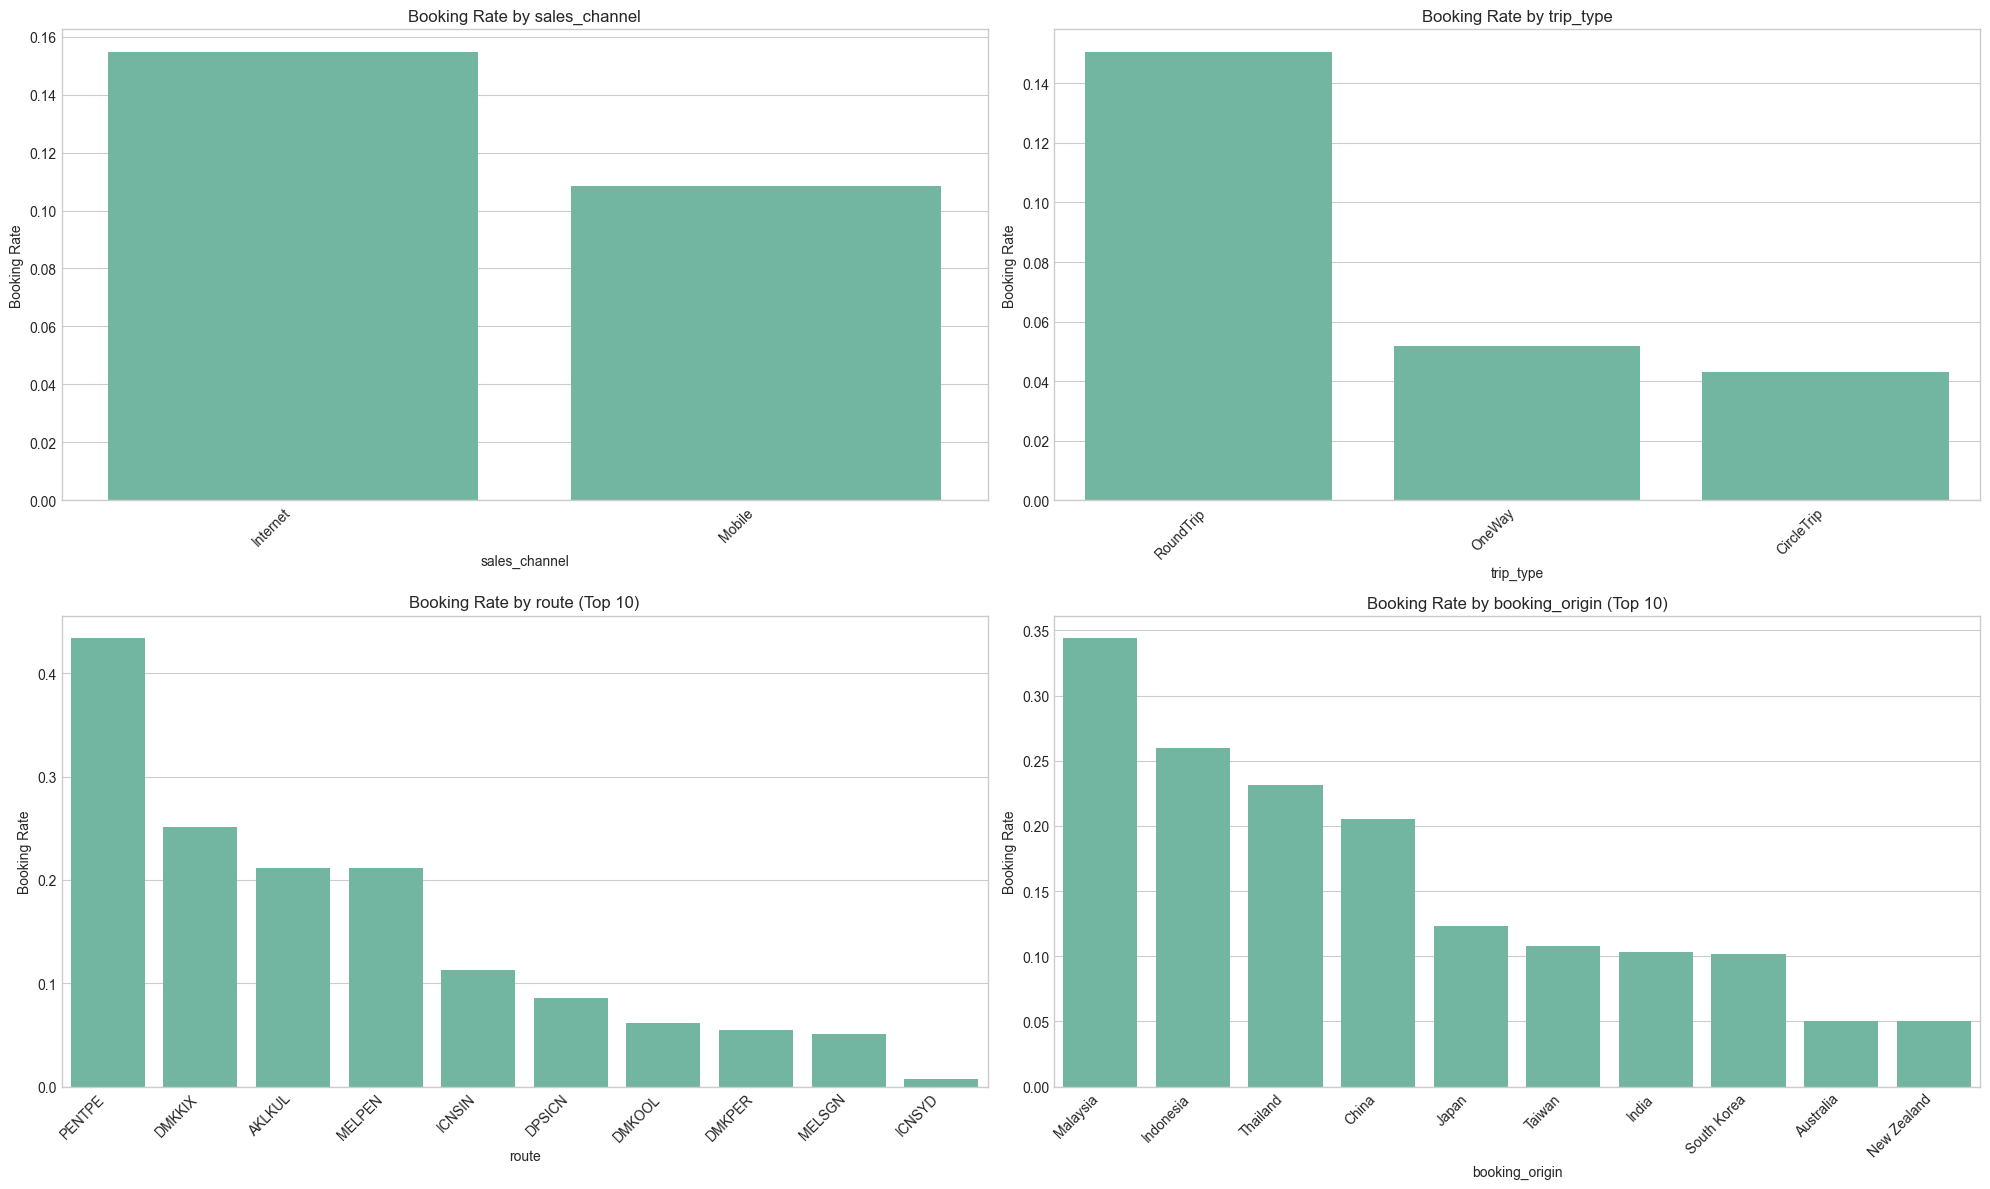

In [ ]:
plt.figure(figsize=(20, 12))
categorical_features = ['sales_channel', 'trip_type', 'route', 'booking_origin']
for i, feature in enumerate(categorical_features):
    plt.subplot(2, 2, i+1)
    if df[feature].nunique() > 10:
        top_values = df[feature].value_counts().nlargest(10).index
        plot_df = df[df[feature].isin(top_values)].copy()
        plt.title(f'Booking Rate by {feature} (Top 10)')
    else:
        plot_df = df.copy()
        plt.title(f'Booking Rate by {feature}')
    booking_rates = plot_df.groupby(feature)['booking_complete'].mean().sort_values(ascending=False) 
    sns.barplot(x=booking_rates.index, y=booking_rates.values)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(feature)
    plt.ylabel('Booking Rate')
plt.tight_layout()
plt.show()

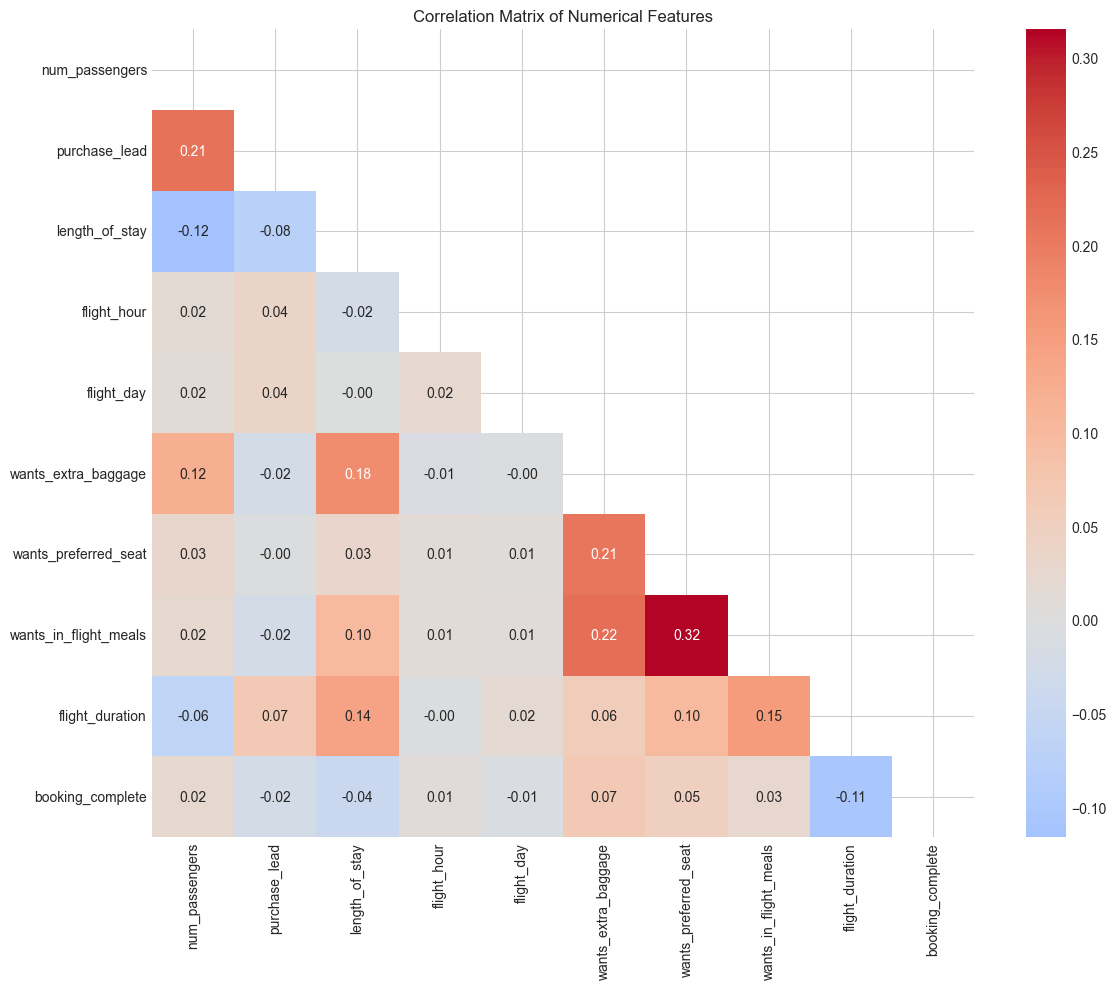

In [ ]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

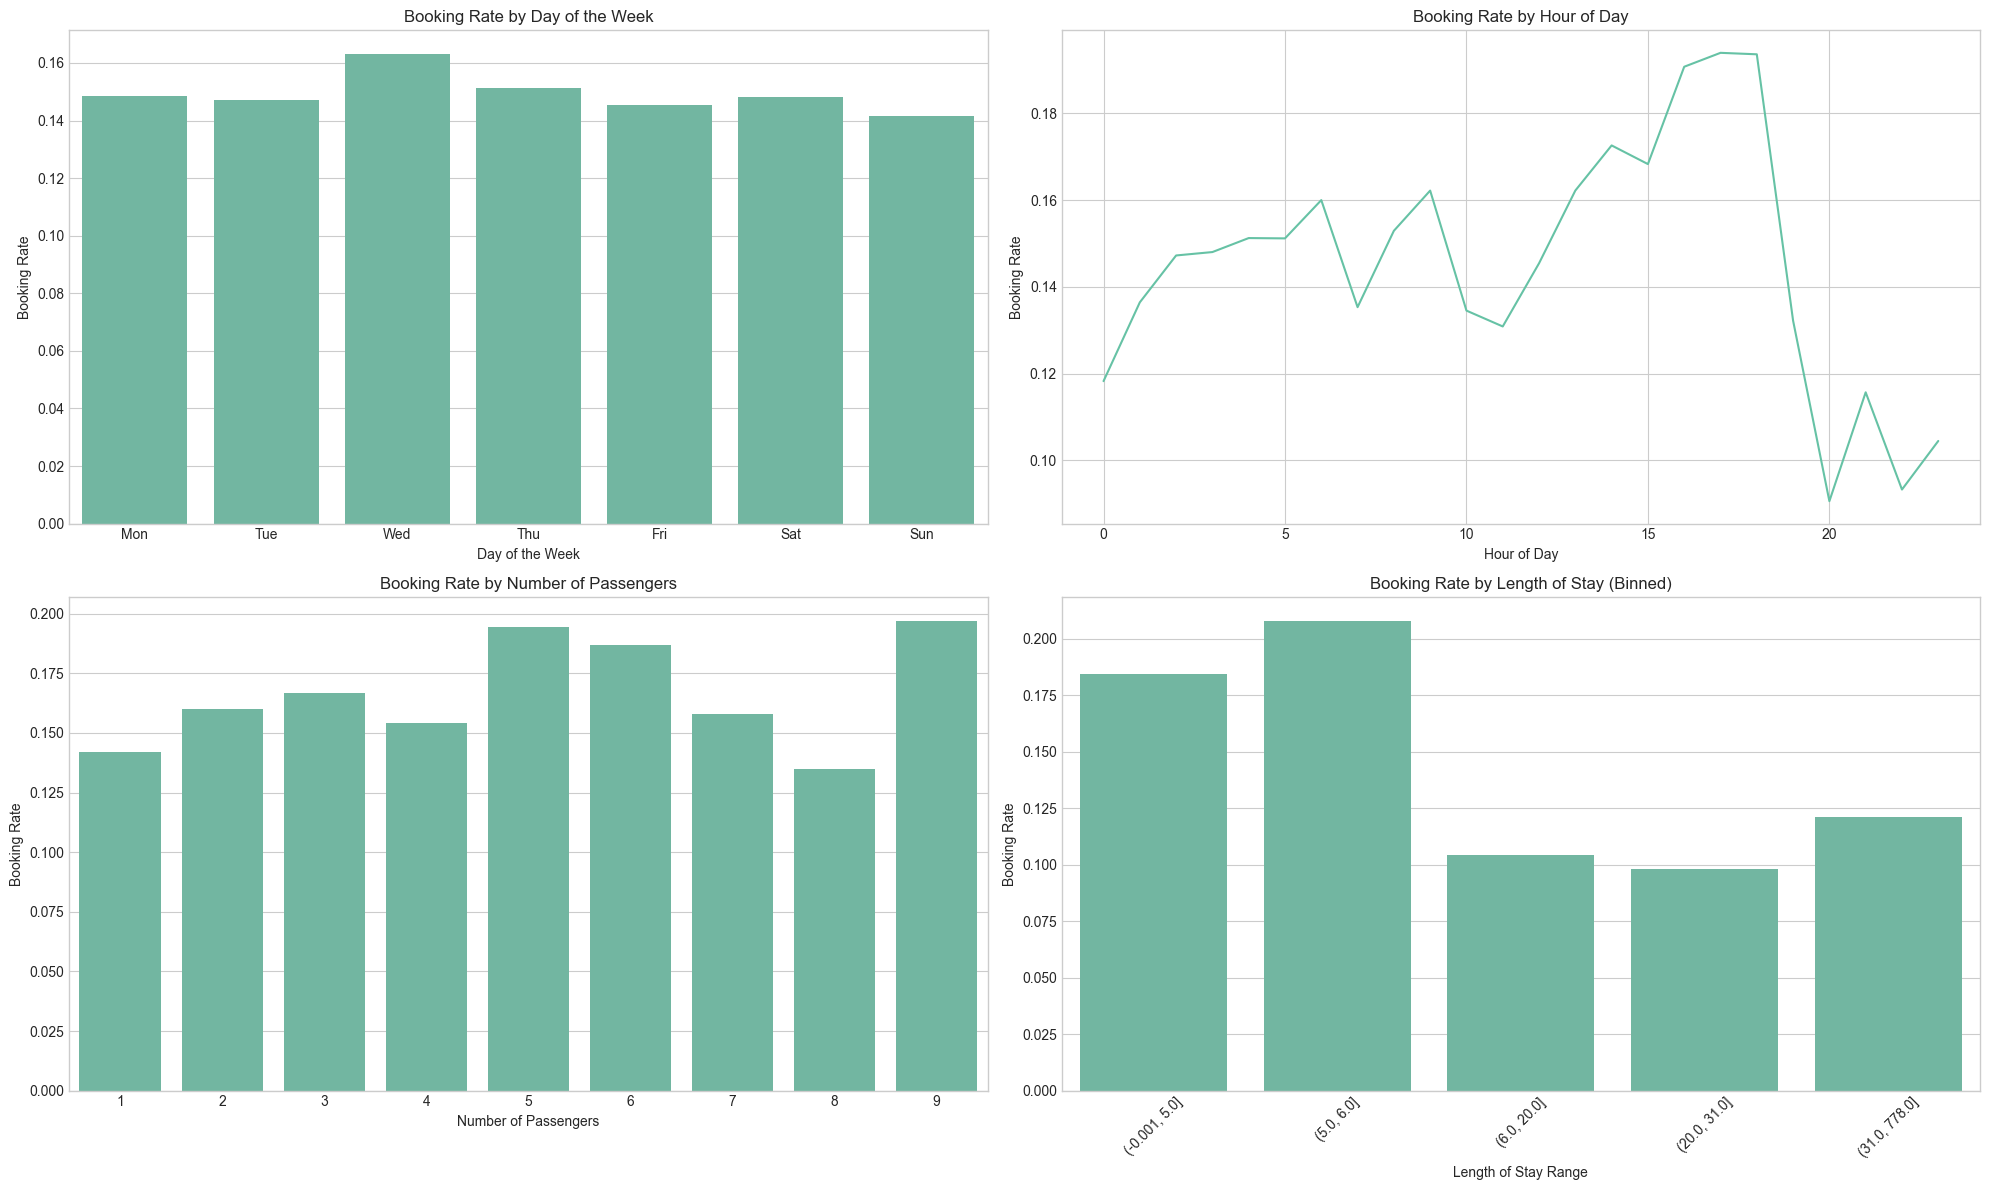

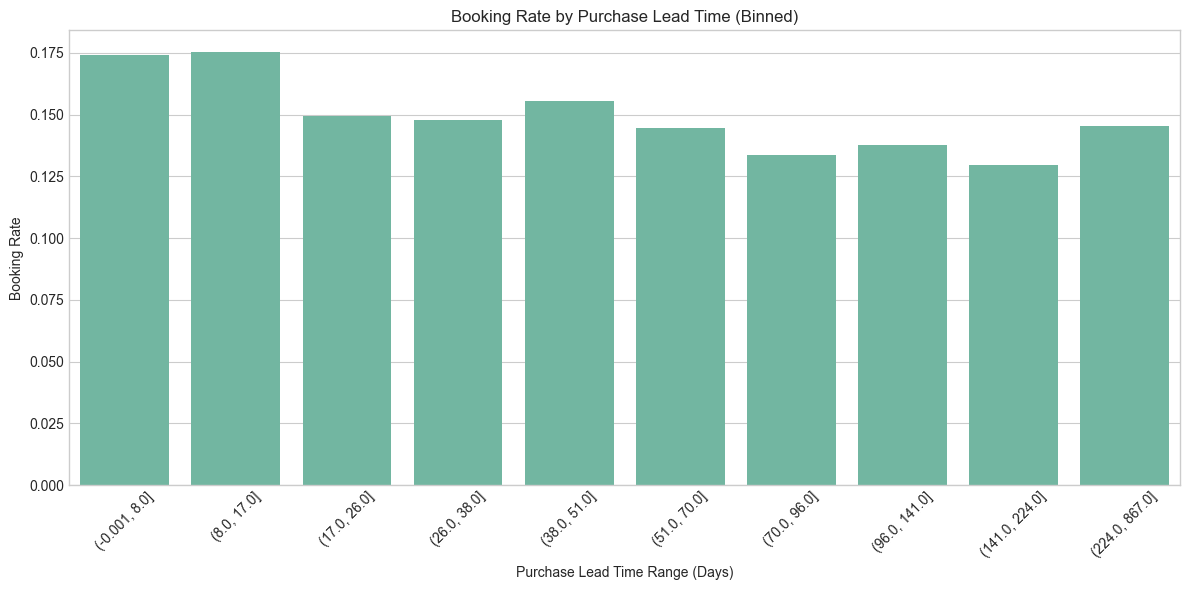

In [ ]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
day_mapping = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}
df['flight_day_name'] = df['flight_day'].map(day_mapping)
booking_rates = df.groupby('flight_day_name')['booking_complete'].mean().reindex(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
sns.barplot(x=booking_rates.index, y=booking_rates.values)
plt.title('Booking Rate by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Booking Rate')
plt.subplot(2, 2, 2)
booking_rates = df.groupby('flight_hour')['booking_complete'].mean()
sns.lineplot(x=booking_rates.index, y=booking_rates.values)
plt.title('Booking Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Booking Rate')
plt.subplot(2, 2, 3)
booking_rates = df.groupby('num_passengers')['booking_complete'].mean()
sns.barplot(x=booking_rates.index, y=booking_rates.values)
plt.title('Booking Rate by Number of Passengers')
plt.xlabel('Number of Passengers')
plt.ylabel('Booking Rate')
plt.subplot(2, 2, 4)
df['stay_bin'] = pd.qcut(df['length_of_stay'], q=5, duplicates='drop')
booking_rates = df.groupby('stay_bin')['booking_complete'].mean()
sns.barplot(x=[str(x) for x in booking_rates.index], y=booking_rates.values)
plt.title('Booking Rate by Length of Stay (Binned)')
plt.xlabel('Length of Stay Range')
plt.ylabel('Booking Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
df['lead_bin'] = pd.qcut(df['purchase_lead'], q=10, duplicates='drop')
booking_rates = df.groupby('lead_bin')['booking_complete'].mean()
sns.barplot(x=[str(x) for x in booking_rates.index], y=booking_rates.values)
plt.title('Booking Rate by Purchase Lead Time (Binned)')
plt.xlabel('Purchase Lead Time Range (Days)')
plt.ylabel('Booking Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Comprehensive Feature Engineering for British Airways Booking Data
df['total_additions'] = df['wants_extra_baggage'] + df['wants_preferred_seat'] + df['wants_in_flight_meals']
df['weekend_flight'] = df['flight_day'].isin([6, 7]).astype(int)
df['early_morning'] = (df['flight_hour'] >= 0) & (df['flight_hour'] < 6)
df['morning'] = (df['flight_hour'] >= 6) & (df['flight_hour'] < 12)
df['afternoon'] = (df['flight_hour'] >= 12) & (df['flight_hour'] < 18)
df['evening'] = (df['flight_hour'] >= 18) & (df['flight_hour'] <= 23)
df['time_of_day'] = 'unknown'
df.loc[df['early_morning'], 'time_of_day'] = 'early_morning'
df.loc[df['morning'], 'time_of_day'] = 'morning'
df.loc[df['afternoon'], 'time_of_day'] = 'afternoon'
df.loc[df['evening'], 'time_of_day'] = 'evening'
df['short_lead'] = (df['purchase_lead'] <= 30).astype(int)
df['purchase_lead_log'] = np.log1p(df['purchase_lead'])
df['length_of_stay_log'] = np.log1p(df['length_of_stay'])
df['short_stay'] = (df['length_of_stay'] <= 3).astype(int)
df['long_stay'] = (df['length_of_stay'] >= 14).astype(int)
df['origin'] = df['route'].str[:3]
df['destination'] = df['route'].str[3:] 
origin_match_conditions = [
    ((df['route'].str[:3] == 'AKL') & (df['booking_origin'] == 'New Zealand')),
    ((df['route'].str[:3] == 'DEL') & (df['booking_origin'] == 'India'))
]
df['origin_matches_booking'] = np.any(origin_match_conditions, axis=0).astype(int)
df['weekend_long_stay'] = df['weekend_flight'] * df['long_stay']
df['num_passengers_has_additions'] = (df['num_passengers'] > 1) & (df['total_additions'] > 0)
df['num_passengers_has_additions'] = df['num_passengers_has_additions'].astype(int)
df['lead_stay_ratio'] = df['purchase_lead'] / (df['length_of_stay'] + 1)
df['lead_time_category'] = pd.cut(
    df['purchase_lead'], 
    bins=[0, 7, 30, 90, float('inf')],
    labels=['last_minute', 'short_term', 'medium_term', 'long_term']
)
day_mapping = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}
df['flight_day_name'] = df['flight_day'].map(day_mapping)
print("\n--- Sample of dataset with new features ---")
display(df[['booking_complete', 'total_additions', 'weekend_flight', 'time_of_day', 
            'short_lead', 'purchase_lead_log', 'length_of_stay_log', 'origin_matches_booking',
            'origin', 'destination', 'short_stay', 'long_stay', 'lead_time_category', 
            'weekend_long_stay', 'lead_stay_ratio']].head())
def plot_feature_importance(model, feature_names, title='Feature Importance'):
    """Helper function to plot feature importance from any model with feature_importances_"""
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    importance_df = importance_df.sort_values('Importance', ascending=False)
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return importance_df


--- Sample of dataset with new features ---


,booking_complete,total_additions,weekend_flight,time_of_day,short_lead,purchase_lead_log,length_of_stay_log,origin_matches_booking,origin,destination,short_stay,long_stay,lead_time_category,weekend_long_stay,lead_stay_ratio
0,0,1,1,morning,0,5.572154,2.995732,1,AKL,DEL,0,1,long_term,1,13.100000
1,0,0,1,early_morning,0,4.727388,3.044522,1,AKL,DEL,0,1,long_term,1,5.333333
2,0,2,0,afternoon,0,5.497168,3.135494,0,AKL,DEL,0,1,long_term,0,10.565217
3,0,1,1,early_morning,0,4.574711,3.465736,1,AKL,DEL,0,1,long_term,1,3.000000
4,0,2,0,afternoon,0,4.234107,3.135494,0,AKL,DEL,0,1,medium_term,0,2.956522


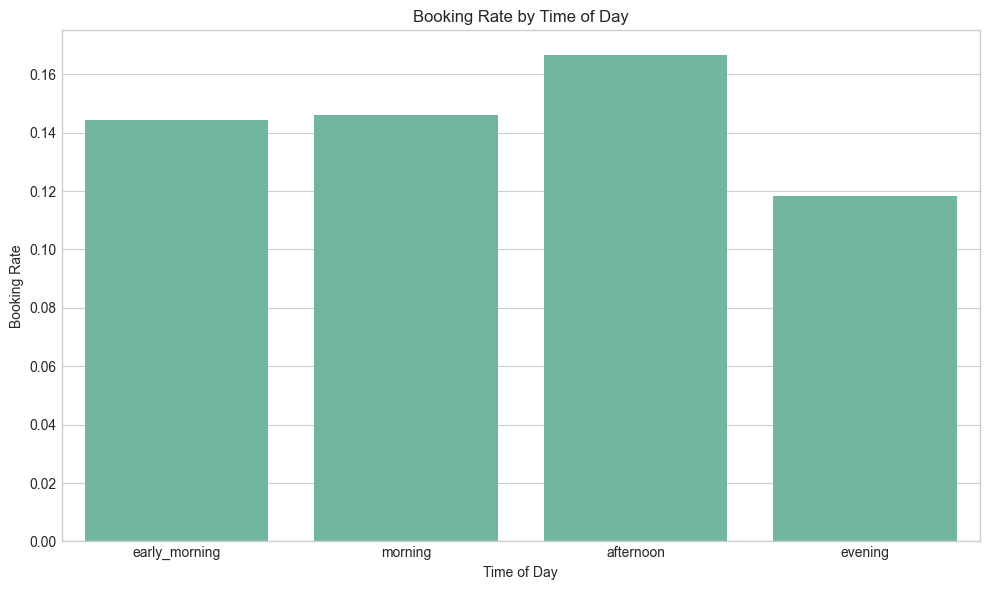

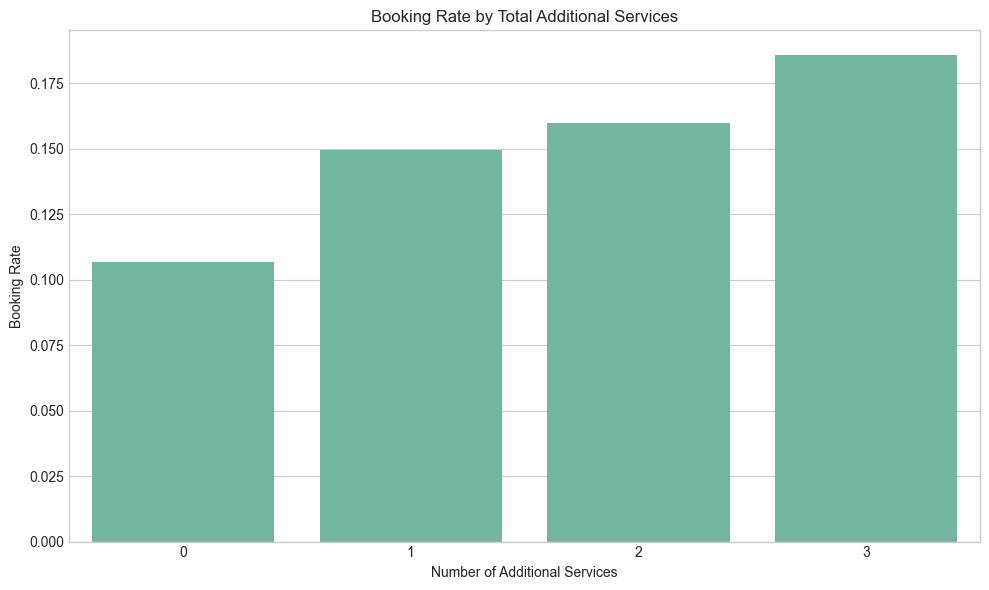

In [ ]:
plt.figure(figsize=(10, 6))
booking_rates = df.groupby('time_of_day')['booking_complete'].mean().reindex(['early_morning', 'morning', 'afternoon', 'evening'])
sns.barplot(x=booking_rates.index, y=booking_rates.values)
plt.title('Booking Rate by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Booking Rate')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))
booking_rates = df.groupby('total_additions')['booking_complete'].mean()
sns.barplot(x=booking_rates.index, y=booking_rates.values)
plt.title('Booking Rate by Total Additional Services')
plt.xlabel('Number of Additional Services')
plt.ylabel('Booking Rate')
plt.tight_layout()
plt.show()

In [ ]:
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']
categorical_features = ['sales_channel', 'trip_type', 'booking_origin', 'time_of_day', 'origin', 'destination']
numerical_features = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day',
                     'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration',
                     'total_additions', 'weekend_flight', 'short_lead', 'purchase_lead_log', 
                     'length_of_stay_log', 'origin_matches_booking']
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



--- Random Forest Best Parameters ---
{'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

--- Random Forest Performance ---
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8504
           1       0.59      0.03      0.06      1496

    accuracy                           0.85     10000
   macro avg       0.72      0.51      0.49     10000
weighted avg       0.81      0.85      0.79     10000



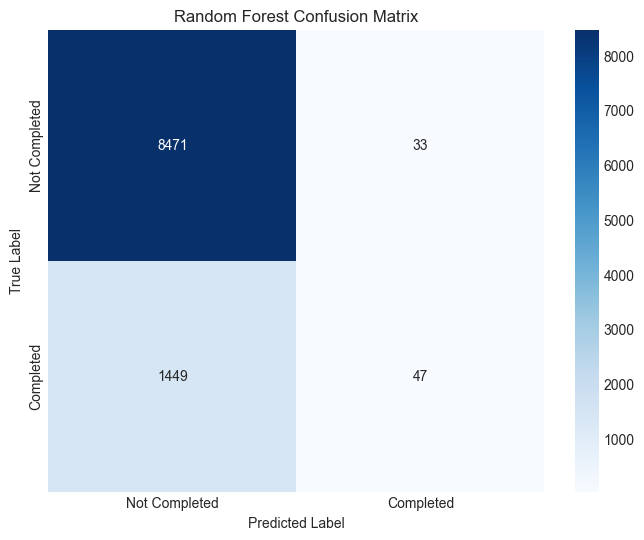

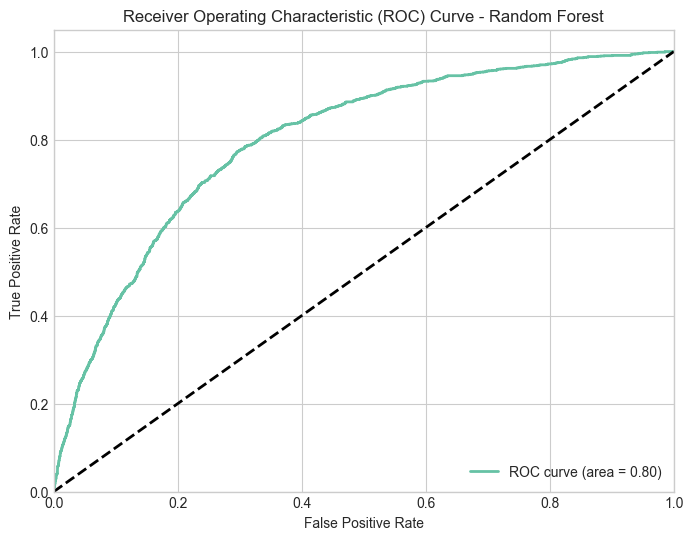

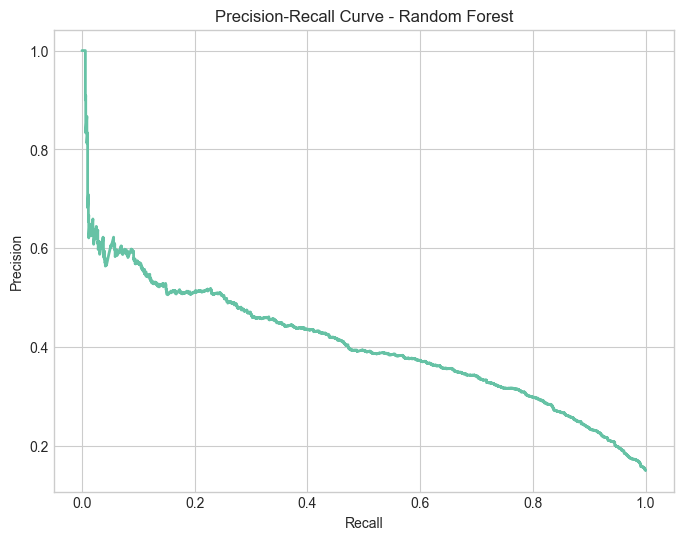

In [ ]:
## 6. Model Building and Evaluation

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("\n--- Random Forest Best Parameters ---")
print(grid_search.best_params_)
best_rf_model = grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
y_pred_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]
print("\n--- Random Forest Performance ---")
print(classification_report(y_test, y_pred_rf))
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5, 1.5], ['Not Completed', 'Completed'])
plt.yticks([0.5, 1.5], ['Not Completed', 'Completed'])
plt.show()
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()
plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_rf)
plt.plot(recall, precision, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest')
plt.show()

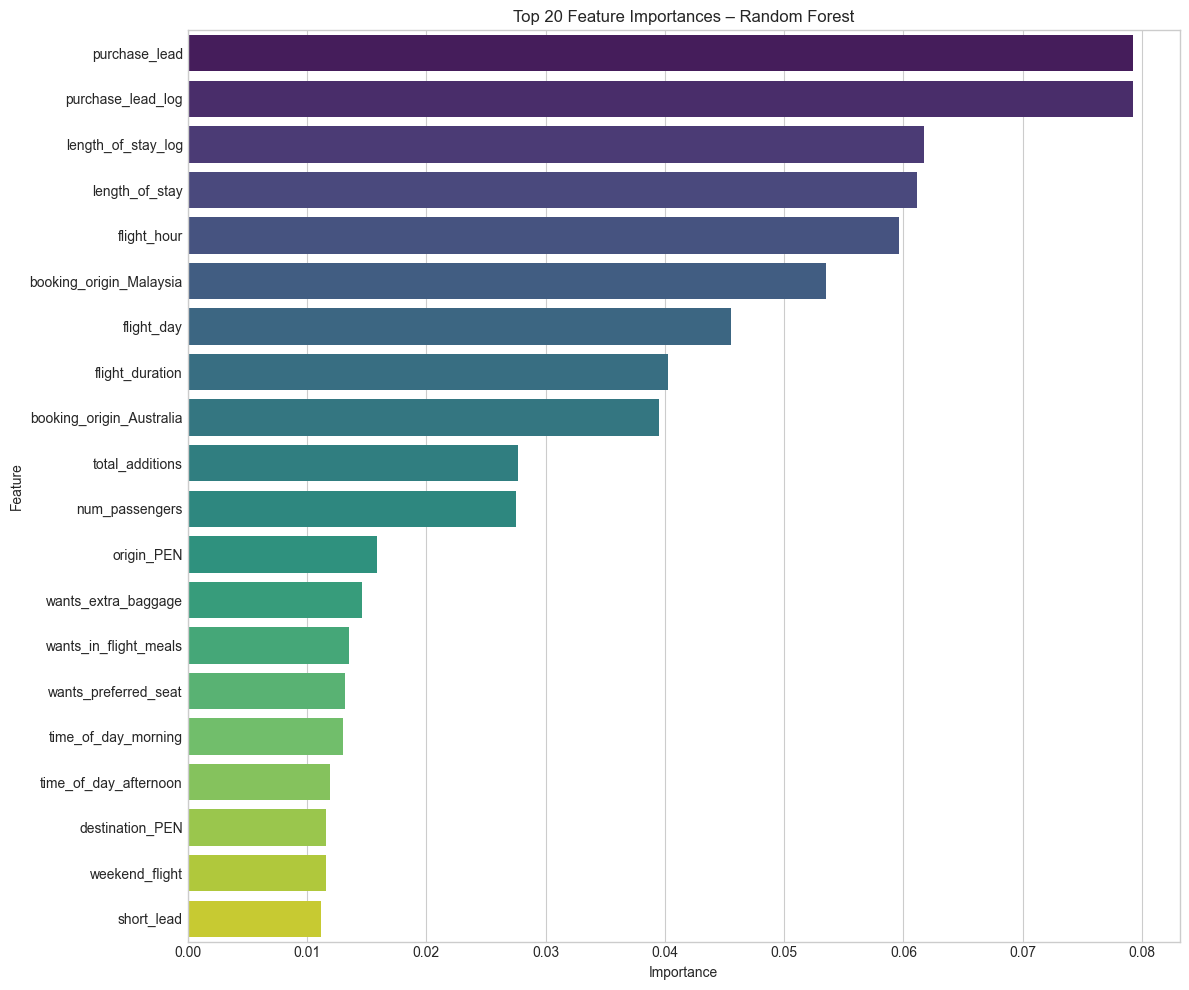

In [ ]:
fitted_preprocessor = best_rf_model.named_steps['preprocessor']
num_features = numerical_features
ohe = fitted_preprocessor.named_transformers_['cat'] \
           .named_steps['onehot']
cat_features = list(ohe.get_feature_names_out(categorical_features))
all_feature_names = num_features + cat_features
importances = best_rf_model.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(
    data=importance_df.head(20),
    x='Importance',
    y='Feature',
    palette='viridis'
)
plt.title('Top 20 Feature Importances – Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


--- Gradient Boosting Best Parameters ---
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}

--- Gradient Boosting Performance ---
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      8504
           1       0.56      0.10      0.17      1496

    accuracy                           0.85     10000
   macro avg       0.71      0.54      0.54     10000
weighted avg       0.82      0.85      0.81     10000



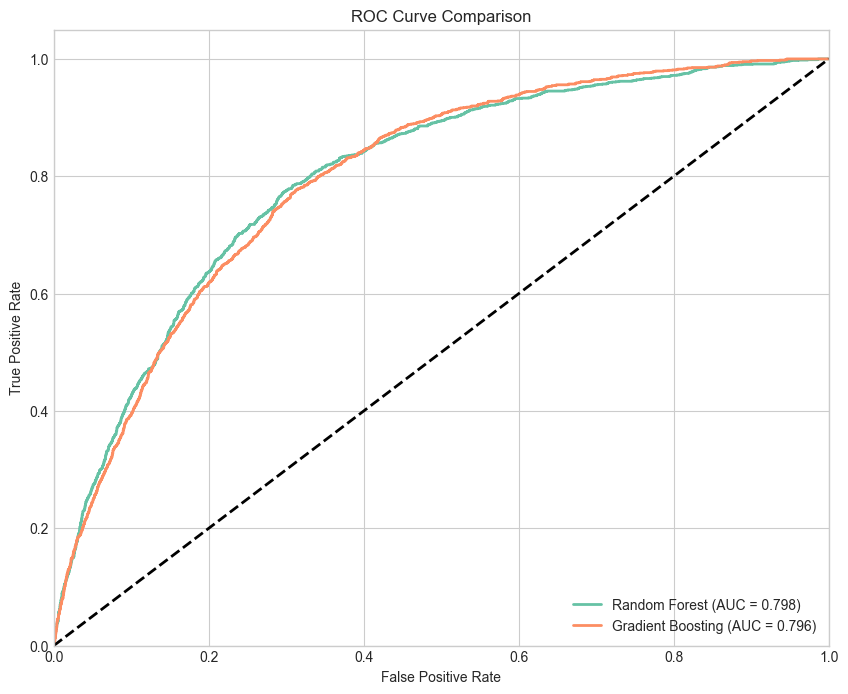

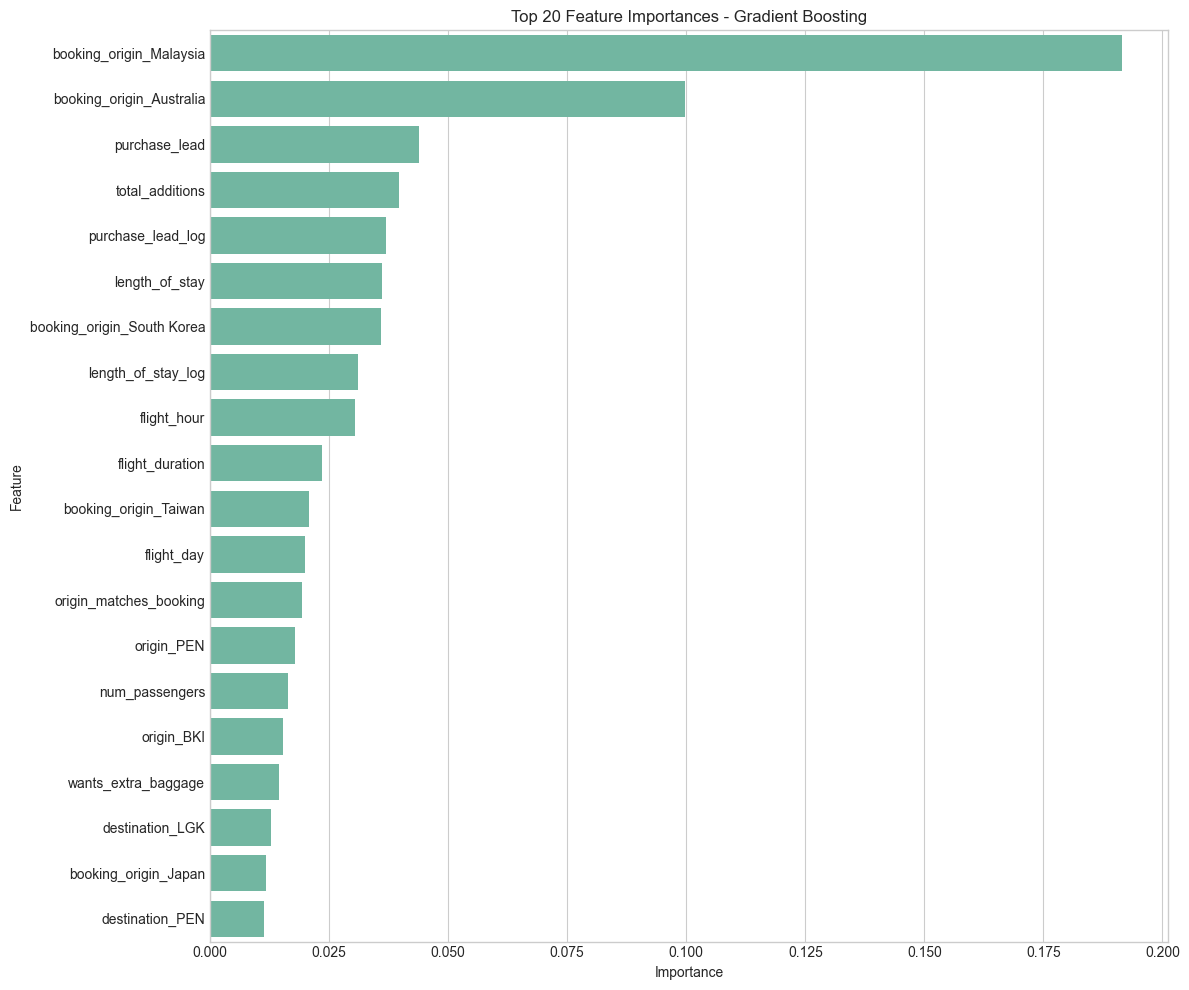

In [ ]:
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])
param_grid_gb = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 5]
}
grid_search_gb = GridSearchCV(gb_pipeline, param_grid_gb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)
print("\n--- Gradient Boosting Best Parameters ---")
print(grid_search_gb.best_params_)
best_gb_model = grid_search_gb.best_estimator_
y_pred_gb = best_gb_model.predict(X_test)
y_pred_prob_gb = best_gb_model.predict_proba(X_test)[:, 1]
print("\n--- Gradient Boosting Performance ---")
print(classification_report(y_test, y_pred_gb))
plt.figure(figsize=(10, 8))
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)
plt.plot(fpr_gb, tpr_gb, lw=2, label=f'Gradient Boosting (AUC = {roc_auc_gb:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
feature_importance_gb = best_gb_model.named_steps['classifier'].feature_importances_
importance_df_gb = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importance_gb
})
importance_df_gb = importance_df_gb.sort_values('Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df_gb.head(20))
plt.title('Top 20 Feature Importances - Gradient Boosting')
plt.tight_layout()
plt.show()

In [ ]:
## 7. Model Comparison and Final Analysis
models = ['Random Forest', 'Gradient Boosting']
accuracy = [
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_gb)
]
precision = [
    precision_score(y_test, y_pred_rf),
    precision_score(y_test, y_pred_gb)
]
recall = [
    recall_score(y_test, y_pred_rf),
    recall_score(y_test, y_pred_gb)
]
f1 = [
    f1_score(y_test, y_pred_rf),
    f1_score(y_test, y_pred_gb)
]
roc_auc = [
    roc_auc_score(y_test, y_pred_prob_rf),
    roc_auc_score(y_test, y_pred_prob_gb)
]
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc
})
print("\n--- Model Comparison ---")
display(comparison_df)
importance_df['Model'] = 'Random Forest'
importance_df_gb['Model'] = 'Gradient Boosting'
combined_importance = pd.concat([importance_df.head(10), importance_df_gb.head(10)])
common_features = set(importance_df.head(10)['Feature']) & set(importance_df_gb.head(10)['Feature'])
print("\n--- Common Top 10 Important Features ---")
print(common_features)
top_common_features = importance_df[importance_df['Feature'].isin(common_features)].sort_values('Importance', ascending=False)
print("\n--- Top Common Features (Random Forest Ranking) ---")
display(top_common_features)


--- Model Comparison ---


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest,0.8518,0.587500,0.031417,0.059645,0.798099
1,Gradient Boosting,0.8534,0.557252,0.097594,0.166098,0.796185



--- Common Top 10 Important Features ---
{'length_of_stay_log', 'flight_hour', 'purchase_lead_log', 'booking_origin_Malaysia', 'purchase_lead', 'total_additions', 'booking_origin_Australia', 'length_of_stay', 'flight_duration'}

--- Top Common Features (Random Forest Ranking) ---


,Feature,Importance,Model
1,purchase_lead,0.079221,Random Forest
12,purchase_lead_log,0.079211,Random Forest
13,length_of_stay_log,0.061695,Random Forest
2,length_of_stay,0.061101,Random Forest
3,flight_hour,0.059663,Random Forest
70,booking_origin_Malaysia,0.053550,Random Forest
8,flight_duration,0.040280,Random Forest
24,booking_origin_Australia,0.039536,Random Forest
9,total_additions,0.027719,Random Forest
